# Wikipedia Data Exploration with Spark
##### Here we are taking a look at one day's worth of pageview data taken from the [Wikistats: Pageview complete dumps](https://dumps.wikimedia.org/other/pageview_complete/).

### Data Ingestion: Reading pageview data from tsv file

In [82]:
import pyspark
import re
import pandas as pd
import seaborn as sns
from datetime import datetime
from itertools import chain
from pyspark.sql import SparkSession, Window, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

# INITIALIZE SPARK SESSION
spark = SparkSession.builder.appName("WikiEDA").getOrCreate()
dump_file = "pageviews-20210101-user"

# DEFINE SCHEMA
pageview_schema = StructType([
    StructField("wikicode", StringType()),
    StructField("title", StringType()),
    StructField("page_id", StringType()),
    StructField("source", StringType()),
    StructField("daily_total", IntegerType()),
    StructField("hourly_total", StringType())
])

In [2]:
## User defined function to transform symbolic time column into timestamp
## More info on hourly count data at: https://dumps.wikimedia.org/other/pageview_complete/readme.html
AZ_time = {
    "A": "00:00:00",
    "B": "01:00:00",
    "C": "02:00:00",
    "D": "03:00:00",
    "E": "04:00:00",
    "F": "05:00:00",
    "G": "06:00:00",
    "H": "07:00:00",
    "I": "08:00:00",
    "J": "09:00:00",
    "K": "10:00:00",
    "L": "11:00:00",
    "M": "12:00:00",
    "N": "13:00:00",
    "O": "14:00:00",
    "P": "15:00:00",
    "Q": "16:00:00",
    "R": "17:00:00",
    "S": "18:00:00",
    "T": "19:00:00",
    "U": "20:00:00",
    "V": "21:00:00",
    "W": "22:00:00",
    "X": "23:00:00"
}


def split_hourly(string): 
    add_delim = re.sub(r'([A-Z])', r',\1', re.sub(r'[,:=/]', '', string))
    return list(filter(None, add_delim.split(',')))

split_hourly_udf = udf(split_hourly, ArrayType(StringType()))


In [3]:
## Extracting view date from file name as there is no date column in the dataset
dump_name_list = dump_file.split('-')
view_date = datetime.strptime(dump_name_list[1], '%Y%m%d').date()

In [4]:
# READ IN DATAFRAME FROM TSV
dump_df = (spark
           .read
           .option("header","false")
           .option("delimiter", " ")
           .schema(pageview_schema)
           .csv(dump_file))

# CACHE DATAFRAMES IN MEMORY
dump_df.persist()

In [5]:
dump_df.printSchema()

root
 |-- wikicode: string (nullable = true)
 |-- title: string (nullable = true)
 |-- page_id: string (nullable = true)
 |-- source: string (nullable = true)
 |-- daily_total: integer (nullable = true)
 |-- hourly_total: string (nullable = true)



In [6]:
dump_df.show(5, truncate=False)

+------------+--------------------+-------+----------+-----------+------------------------------------------------+
|wikicode    |title               |page_id|source    |daily_total|hourly_total                                    |
+------------+--------------------+-------+----------+-----------+------------------------------------------------+
|aa.wikibooks|-                   |null   |mobile-web|4          |I1O2R1                                          |
|aa.wikibooks|File:Wikimania.svg  |null   |mobile-web|1          |I1                                              |
|aa.wikibooks|Main_Page           |null   |desktop   |168        |A5B1C3E5F3G3H4I3J2K68L35M2N2O5P7Q1R3S2T2U4V2W2X4|
|aa.wikibooks|Main_Page           |null   |mobile-web|9          |C1F1I2Q2T2U1                                    |
|aa.wikibooks|Special:CiteThisPage|null   |mobile-web|1          |Q1                                              |
+------------+--------------------+-------+----------+-----------+------

### Data Exploration and Preparation by Transforming

In [7]:
## Number of rows pre-cleaning
dump_df.count()

36859696

#### Filter out null values, default landing pages, and filter data by English language Wikipedia

In [8]:
dump_df = dump_df.filter((dump_df.page_id != 'null') & (dump_df.wikicode == 'en.wikipedia') & (dump_df.title != 'Main_Page'))
dump_df = dump_df.sort(dump_df.daily_total.desc())
dump_df.show(5, truncate=False)

+------------+--------------+--------+----------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|wikicode    |title         |page_id |source    |daily_total|hourly_total                                                                                                                                    |
+------------+--------------+--------+----------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|en.wikipedia|MF_Doom       |923002  |mobile-web|764015     |A94553B73214C57827D48006E41712F34050G30431H25319I23782J22346K21292L20499M20986N22412O24242P25828Q27643R27409S24962T22864U20934V19545W18330X15829|
|en.wikipedia|Bridgerton    |62811365|mobile-web|204812     |A7630B8001C7985D8000E7354F6559G6213H5439I4812J4912K4998L5273M5650N6303O7242P8724Q9720R10380S10985T12281U14120V1

In [9]:
## Checking if page_id contains leading zeroes
dump_df.sort(dump_df.page_id).show(1)

+------------+--------------+-------+-------+-----------+------------+
|    wikicode|         title|page_id| source|daily_total|hourly_total|
+------------+--------------+-------+-------+-----------+------------+
|en.wikipedia|Felicity_Lemon|   1000|desktop|          4|        G2R2|
+------------+--------------+-------+-------+-----------+------------+
only showing top 1 row



In [10]:
## Number of rows after focusing on English Wikipedia and pages with IDs
dump_df.count()

9136437

In [11]:
## Refer to https://en.wikipedia.org/wiki/Category:Articles_with_underscores_in_the_title 
## for the 83 articles that have an underscore in the title.
dump_df = dump_df.drop("wikicode")

## Adding date column
dump_df = (dump_df
           .withColumn("title", regexp_replace("title", "_", " "))
           .withColumn("page_id", dump_df.page_id.cast(IntegerType()))
           .withColumn("views_date", lit(view_date)).select("views_date", *dump_df.columns)           
          )

dump_df.show(5, truncate=False)

+----------+--------------+--------+----------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|views_date|title         |page_id |source    |daily_total|hourly_total                                                                                                                                    |
+----------+--------------+--------+----------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------+
|2021-01-01|MF Doom       |923002  |mobile-web|764015     |A94553B73214C57827D48006E41712F34050G30431H25319I23782J22346K21292L20499M20986N22412O24242P25828Q27643R27409S24962T22864U20934V19545W18330X15829|
|2021-01-01|Bridgerton    |62811365|mobile-web|204812     |A7630B8001C7985D8000E7354F6559G6213H5439I4812J4912K4998L5273M5650N6303O7242P8724Q9720R10380S10985T12281U14120V15425W14034

In [12]:
## Checking distribution of pageviews amongst sources
source_types = dump_df.groupBy("source").agg(countDistinct("page_id"))
source_types.show()

+----------+--------------+
|    source|count(page_id)|
+----------+--------------+
|   desktop|       3818417|
|mobile-app|            37|
|mobile-web|       3527083|
+----------+--------------+



In [13]:
page_df = dump_df.groupBy("title", "page_id").count().sort("page_id")
page_df = page_df.drop("count")
page_df.show(10)

+--------------------+-------+
|               title|page_id|
+--------------------+-------+
|   Political anarchy|     12|
|List of anarchist...|     12|
|                   -|     12|
|           Anarchist|     12|
|   Anarchist society|     12|
|Criticism of anar...|     12|
|           Anarchism|     12|
|Criticisms of ana...|     12|
|Revolutionary ana...|     12|
|  Anarchism (theory)|     12|
+--------------------+-------+
only showing top 10 rows



6036877

#### Create dataframe for daily pageviews by pivoting by source and aggregating by title, page_id, and date

In [14]:
daily_df = (dump_df
            .groupBy("title","page_id","views_date")
            .pivot("source")
            .max("daily_total")
            .sort("page_id")
           )

daily_df.show(10)

+--------------------+-------+----------+-------+----------+----------+
|               title|page_id|views_date|desktop|mobile-app|mobile-web|
+--------------------+-------+----------+-------+----------+----------+
|  Anarchism (theory)|     12|2021-01-01|      1|      null|      null|
|                   -|     12|2021-01-01|      4|      null|      null|
|List of anarchist...|     12|2021-01-01|   null|      null|         1|
|Criticisms of ana...|     12|2021-01-01|      1|      null|      null|
|Revolutionary ana...|     12|2021-01-01|      1|      null|      null|
|           Anarchist|     12|2021-01-01|     79|      null|       165|
|Criticism of anar...|     12|2021-01-01|      1|      null|         3|
|      Anti-anarchism|     12|2021-01-01|      1|      null|      null|
|   Anarchist society|     12|2021-01-01|   null|      null|         1|
|   Political anarchy|     12|2021-01-01|   null|      null|         6|
+--------------------+-------+----------+-------+----------+----

In [15]:
daily_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- page_id: integer (nullable = true)
 |-- views_date: date (nullable = false)
 |-- desktop: integer (nullable = true)
 |-- mobile-app: integer (nullable = true)
 |-- mobile-web: integer (nullable = true)



#### Create hourly dataframe by exploding and applying "split_hourly" UDF

In [16]:
hourly_df = (dump_df
             .drop("daily_total")
             .withColumn("hourly_total", split_hourly_udf("hourly_total"))
             .withColumn("hourly_total", explode("hourly_total"))
            )

mapping = create_map([lit(x) for x in chain(*AZ_time.items())])

hourly_df = (hourly_df
             .withColumn("time_indicator", regexp_extract("hourly_total", pattern="[A-Z]", idx=0))
             .withColumn("hourly_total", regexp_replace("hourly_total", "[A-Z]", ""))
            )

hourly_df = hourly_df.withColumn("time_indicator", mapping[hourly_df['time_indicator']])
hourly_df = (hourly_df
             .withColumn('views_datetime', to_timestamp(concat(col('views_date'), lit(' '), col('time_indicator'))))
             .withColumn("hourly_total", hourly_df.hourly_total.cast(IntegerType()))
             .drop("views_date")
             .drop("time_indicator")
            )

hourly_df.show(2)

+-------+-------+----------+------------+-------------------+
|  title|page_id|    source|hourly_total|     views_datetime|
+-------+-------+----------+------------+-------------------+
|MF Doom| 923002|mobile-web|       94553|2021-01-01 00:00:00|
|MF Doom| 923002|mobile-web|       73214|2021-01-01 01:00:00|
+-------+-------+----------+------------+-------------------+
only showing top 2 rows



In [17]:
hourly_df = (hourly_df
            .groupBy("title","page_id","views_datetime")
            .pivot("source")
            .max("hourly_total")
            .sort("page_id", "views_datetime")
           )

hourly_df.show(15)

+--------------------+-------+-------------------+-------+----------+----------+
|               title|page_id|     views_datetime|desktop|mobile-app|mobile-web|
+--------------------+-------+-------------------+-------+----------+----------+
|           Anarchist|     12|2021-01-01 00:00:00|      2|      null|         9|
|Criticism of anar...|     12|2021-01-01 00:00:00|   null|      null|         2|
|          Anarchists|     12|2021-01-01 00:00:00|   null|      null|         1|
|           Anarchism|     12|2021-01-01 00:00:00|     33|      null|        81|
|   Political anarchy|     12|2021-01-01 00:00:00|   null|      null|         1|
|           Anarchism|     12|2021-01-01 01:00:00|     38|      null|       104|
|           Anarchist|     12|2021-01-01 01:00:00|      3|      null|         7|
|          Anarchists|     12|2021-01-01 01:00:00|      1|      null|         4|
|   Political anarchy|     12|2021-01-01 01:00:00|   null|      null|         1|
|           Anarchist|     1

In [96]:
## Creating dateframe for sum aggregation by title for visualization
pop_df = dump_df.groupBy("page_id", "title").agg(sum("daily_total").alias("daily_total"))

w = Window.partitionBy("page_id").orderBy(col("daily_total").desc())

pop_df = (pop_df
          .withColumn("row_n", row_number().over(w))
          .where(col("row_n") == 1)
          .select("title", "daily_total")
          .sort(col("daily_total").desc())
          .limit(10)
         )

#### Plot of pageviews per article in descending order on New Year's Day 2021

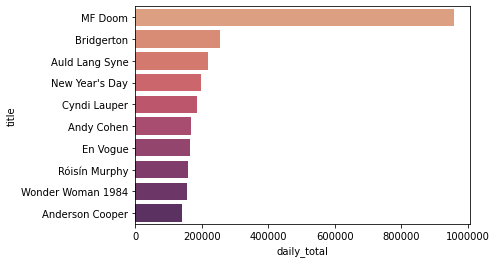

In [100]:
pd_df = pop_df.toPandas()
plot = sns.barplot(x = "daily_total", y = "title", data = pd_df, palette="flare")
plot.ticklabel_format(style="plain", axis="x")